In [26]:
import numpy as np
import networkx as nx
import graph_generator as gg
import graph_visualiser as gv
import importlib

In [ ]:
importlib.reload(gg)
importlib.reload(gv)

## Zad 3. Analiza obwodu elektrycznego

#### Funkcja znajdująca natężenie w poszczególnych częściach obwodu z użyciem praw Kirchoffa
Funkcja przyjmuje na wejściu obiekt typy nx.Graph(), a także parę wierzchołków s oraz t, między którymi została przyłożona siła elektromotoryczna e.
Niczego nie zwraca, modyfikuje jedynie wartość natężenia na każdej krawędzi.( Każda krawędź grafu jest reprezentowana przez obiekt Edge, która posiada między innymi atrybut current opisujący natężenie)

Przyjmuje, że umowny kierunek prądu zawsze prowadzi z wierzchołka o mniejszym indeksie do wierzchołka o większym indeksie( wierzchołki grafu są opisywane przez kolejne liczby naturalne począwszy od zera). Dzięki temu nie muszę przechowywać nigdzie informacji o przyjętym umównym kierunku prądu na krawędzi, gdyż obiekt Edge, przechowuje informacje o wierzchołkach z którymi dana krawędź jest incydentna.

Do wyznaczenia cykli prostych użyłem funkcji z biblioteki networkx cycle_basis(), która przyjmuje graf i zwraca "cycle basis", czyli minimalny zbiór cykli prostych takich, że każdy cykl w grafie da się przedstawić jako sumę cykli z tego zbioru.

Układ równań rozwiązuje z użyciem funkcji numpy.linalg.solve(), lecz funkcja ta nie rozwiązuje nadokreśłonych układów równań, więc najpierw muszę równanie macierzowe pomnożyć lewostronnie przez macierz transponowaną do macierzy układu.

In [28]:
def kirchoff(g, s, t, e):
    def add_sum_component(v1, v2):
        edge = g[v1][v2]['edge']
        if (v1, v2) == (s, t) or (v1, v2) == (t, s):
            if v1 < v2:
                B[eq_no] -= e
            else:
                B[eq_no] += e
        else:
            if v1 < v2:
                A[eq_no][edge.index] += edge.resistance
            else:
                A[eq_no][edge.index] -= edge.resistance

    n = g.number_of_nodes()
    m = g.number_of_edges()

    cycle_basis = nx.cycle_basis(g)
    no_of_eq = n + len(cycle_basis)
    A = np.zeros((no_of_eq, m))
    B = np.zeros(no_of_eq)

    eq_no = 0
    for cycle in cycle_basis:
        for i in range(1, len(cycle)):
            add_sum_component(cycle[i-1], cycle[i])
        add_sum_component(cycle[-1], cycle[0])
        eq_no += 1

    for v in range(n):
        for neighbor in g.neighbors(v):
            edge = g[v][neighbor]['edge']
            if v < neighbor:
                A[eq_no][edge.index] += 1
            else:
                A[eq_no][edge.index] -= 1
        eq_no += 1

    transposed = A.T
    ans = np.linalg.solve(np.matmul(transposed, A), np.matmul(transposed, B))
    for a, b in g.edges:
        edge = g[a][b]['edge']
        edge.current = ans[edge.index]

#### Znajdowanie natężeń metodą potencjałów węzłowych

Funkcja przyjmuje te same argumenty co kirchoff() i tak samo nic nie zwraca tylko modyfikuje dany graf.

Umowny kierunek prądu wyznaczam tak samo jak w kirchoffie. Potencjał 0 przyjmuje w wierzchołku s. Wtedy wierzchołek t musi mieć potencjał E.
Powstała macierz układu jest kwadratowa, więc można ją rozwiązać z użyciem np.linalg.solve. Natężenia znajduje dzieląc różnicę potencjałów na danej krawędzi przez jej opór.


In [29]:
def nodal_potentials(g, s, t, e):
    n = g.number_of_nodes()
    A = np.zeros((n, n))
    B = np.zeros(n)
    A[s][s] = 1
    B[s] = e
    A[t][t] = 1
    B[t] = 0

    for v in range(n):
        if v != s and v != t:
            for neighbor in g.neighbors(v):
                edge = g[v][neighbor]['edge']
                A[v][v] += 1/edge.resistance
                A[v][neighbor] -= 1/edge.resistance

    potentials = np.linalg.solve(A, B)
    for a, b in g.edges:
        edge = g[a][b]['edge']
        if a < b:
            edge.current = (potentials[a] - potentials[b]) / edge.resistance
        else:
            edge.current = (potentials[b] - potentials[a]) / edge.resistance

#### Generowanie, wczytywanie i rysowanie grafów

Można wczytać gotowy graf podając nazwę pliku z folderu saved_graphs

Funkcja load_graph z modułu graph_generator wczytuje graph i zwraca graf(obiekt typu nx.Graph), wierzchołki między którymi przyłożono siłę elektromotoryczną i wartość tej siły

Rysowanie grafu odbywa się za pośrednictwem modołu graph_visualiser.

Funkcja draw_with_resistance rysuje graf nieskierowany, na niebiesko jest zaznaczona krawędź na której jest napięcie
Funkcja draw_with_current rysuje graf skierowany krawędzie oznaczają kierunek prądu

Parametr size_param odpowiada za wymiary plotu wygenerowanego przez matplotlib

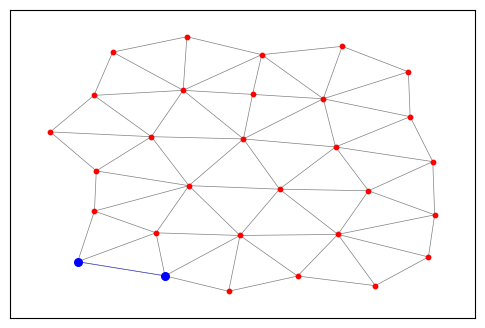

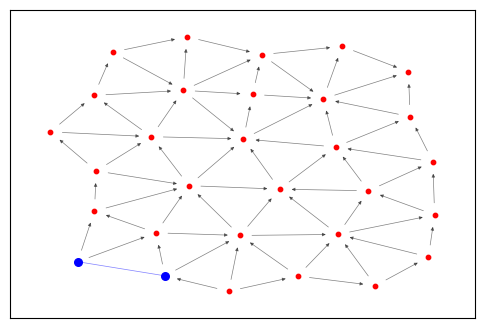

In [30]:
G, source, target, E = gg.load_graph("triangulation_small")
gv.draw_with_resistance(G, source, target, E, size_param=(6, 4))
gv.draw_with_current(G, source, target, E, size_param=(6, 4))

Do obu funkcji można przekazać flagę small, jeśli small==True to dodatkowo pokaża się wartości oporu na każdej krawędzi( w grafie nieskierowanym) lub wartości natężeń ( w grafie skierowanym ), a także wartość napięcia. Parametr nazywa się small, gdyż dla dużych graf etykiety stają się nieczytelne

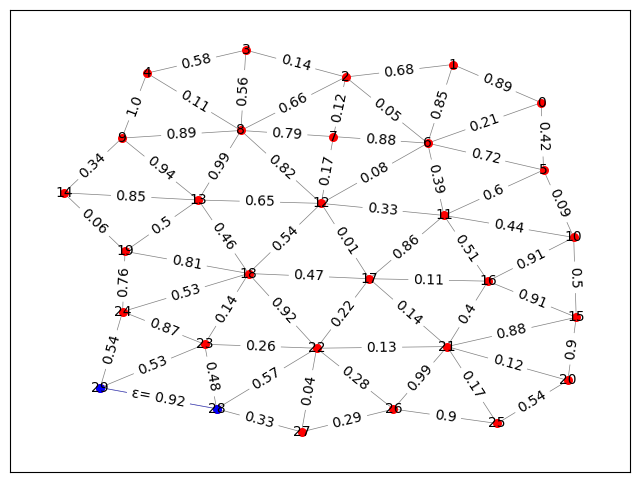

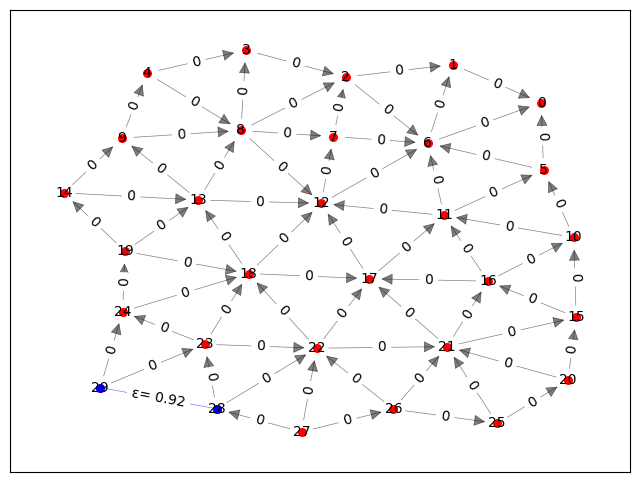

In [31]:
gv.draw_with_resistance(G, source, target, E, small=True, size_param=(8, 6))
gv.draw_with_current(G, source, target, E, small=True, size_param=(8, 6))

Początkowo wartości natężeń to oczywiście zero, gdyż nie została uruchomiona żadna funkcja rozwiązująca układ

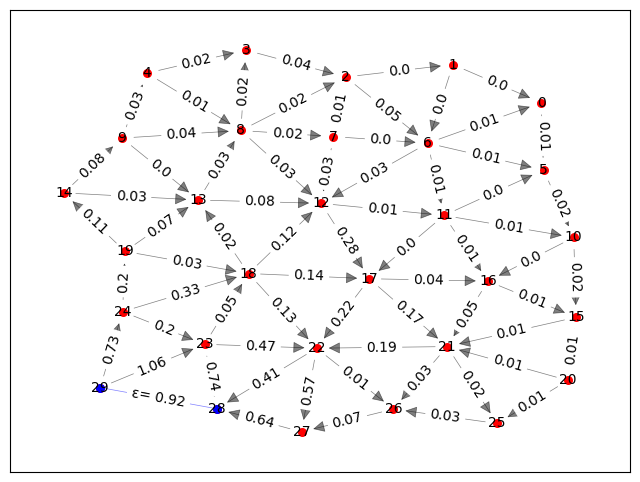

In [32]:
kirchoff(G, source, target, E)
gv.draw_with_current(G, source, target, E, small=True, size_param=(8, 6))

Funkcja nodal_potentials przyjmuje już graf z uzupełnionymi wartościami natężeń (żeby nie robić kopii), lecz są one potem nadpisywane wartościami uzyskanymi metodą potencjałów węzłowych

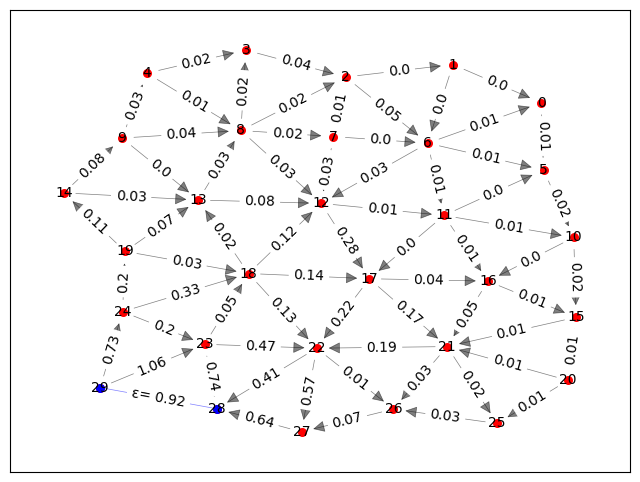

In [33]:
nodal_potentials(G, source, target, E)
gv.draw_with_current(G, source, target, E, small=True, size_param=(8, 6))

Wyświetlane wartości natężeń zaokrąglam do dwóch miejsc po przecinku, więc z tego względu na rysunku mogą się pojawić niezgodności z I prawem Kirchoffa

W module graph_generator dostępne są także funkcje genereujące losowo grafy różnego typu ( zwracają tą sąmą czwórkę co load_graph)

- generate_erdos_renyi(n, p) - generuje graf typu Erdos-Renyi, gdzie n to ilość wierzchołków, a p to prawdopodobieństwo stworzenia krawędzi
- generate_cubic(n) - generuje graf 3-regularny o n wierzchołkach, n powinno być liczbą parzystą
- generate_bridge_graph(n, m, p1, p2) - generuje dwa grafy typu Erdos-Renyi i łączy je jedną krawędzią (n, p1) to ilośc wierzchołków i prawdopodobieństwo stworzenia krawędzi w pierwszym grafie, a (m, p2) te same wartości ale dla drugiego grafu
- generate_small_world(n, k, p) - generuje spójny graf typu Watts–Strogatz small-world, n to liczba wierzchołków( początkowo graf jest generowany jako n punktów na okręgu), k oznacza z iloma najbliższymi(w topologii pierścienia) sąsiadami ma być połączony każdy wierzchołek, następnie p oznacza prawdopodobieństwo że któraś z krawędzi zostaje usunięta i zastąpiona inną losową krawędzią
- generate_2d_mesh(m, n) - generuje siatkę 2d, wynikowy graf ma m*n wierzchołków
- generate_triangulation(m, n) - podobnie jak siatka 2d, lecz dodatkowo dodaje przękątne

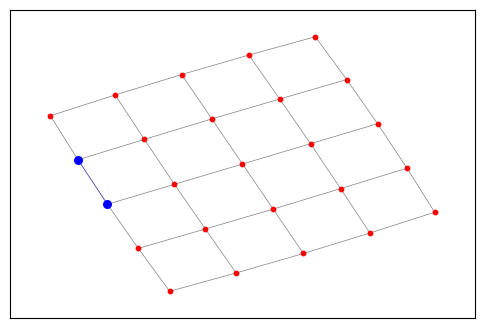

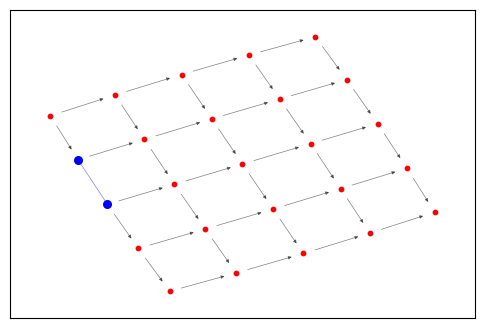

In [19]:
G, source, target, E = gg.generate_2d_mesh(5, 5)
gv.draw_with_resistance(G, source, target, E, size_param=(6, 4))
gv.draw_with_current(G, source, target, E, size_param=(6, 4))

#### Sprawdzenie poprawności algorytmów

Funkcja sprawdza czy suma natężeń w każdym węźle jest bliska zeru

In [14]:
def check_currents(g, s, t):
    eps = pow(10, -9)
    for v in range(g.number_of_nodes()):
        if v != s and v != t:
            current_sum = 0
            for neighbor in g.neighbors(v):
                if v < neighbor:
                    current_sum += g[v][neighbor]['edge'].current
                else:
                    current_sum -= g[v][neighbor]['edge'].current
            if abs(current_sum) > eps:
                return False
    return True

Po zakończeniu jednego z algorytmów zapamiętuje wartości natężęń, aby potem dało się je porównać z drugim algorytmem

In [15]:
def save_current_values(g, s, t):
    current_values = []
    for a, b in g.edges:
        if (a, b) not in [(s, t), (t, s)]:
            current_values.append(g[a][b]['edge'].current)
    return current_values

Porównanie wektorów

In [16]:
def cmp_vectors(v1, v2):
    eps = pow(10, -9)
    for a, b in zip(v1, v2):
        if abs(a - b) > eps:
            return False
    return True

#### Sprawdzenie poprawności dla kilku przykładowych grafów

-------------
Nazwa grafu: bridge_graph_1
Ilość wierzchołków: 35
Ilość krawędzi: 103


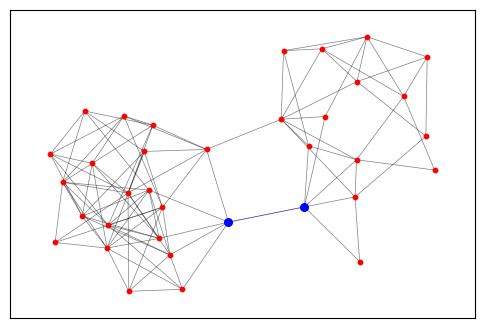

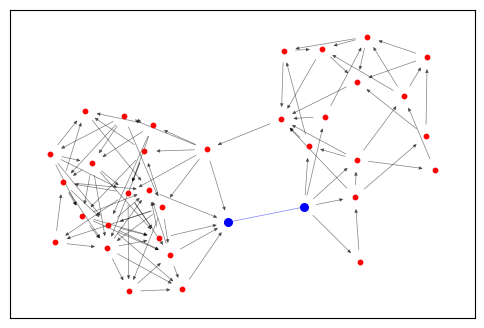

Porównanie wyników obu algorytmów(wartość funkcji cmp_vectors) dla grafu bridge_graph_1: True
Sprawdzenie zgodności z pierwszym prawem Kirchoffa: True



-------------
Nazwa grafu: bridge_graph_2
Ilość wierzchołków: 13
Ilość krawędzi: 21


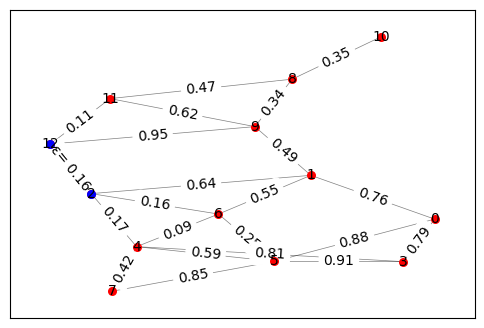

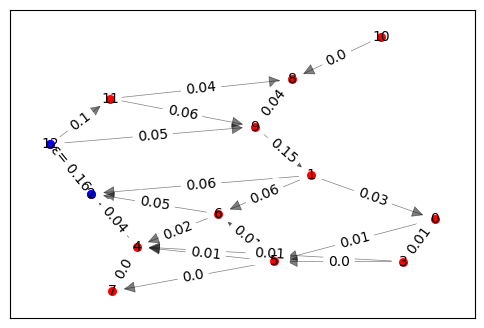

Porównanie wyników obu algorytmów(wartość funkcji cmp_vectors) dla grafu bridge_graph_2: True
Sprawdzenie zgodności z pierwszym prawem Kirchoffa: True



-------------
Nazwa grafu: cubic_large
Ilość wierzchołków: 200
Ilość krawędzi: 300


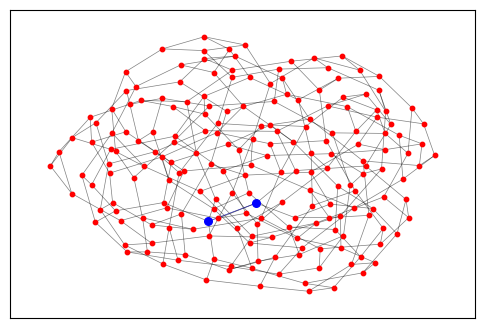

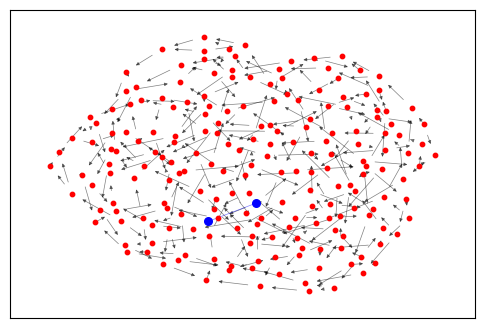

Porównanie wyników obu algorytmów(wartość funkcji cmp_vectors) dla grafu cubic_large: True
Sprawdzenie zgodności z pierwszym prawem Kirchoffa: True



-------------
Nazwa grafu: cubic_small
Ilość wierzchołków: 26
Ilość krawędzi: 39


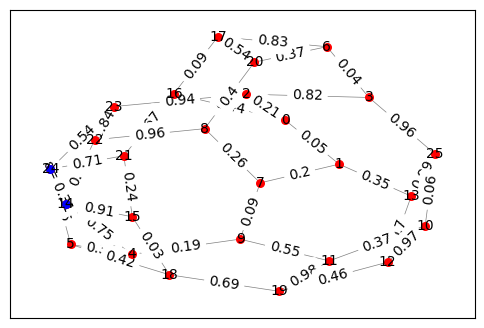

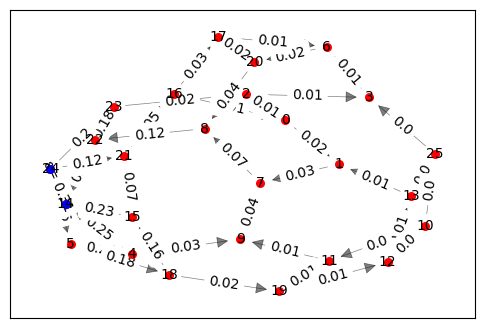

Porównanie wyników obu algorytmów(wartość funkcji cmp_vectors) dla grafu cubic_small: True
Sprawdzenie zgodności z pierwszym prawem Kirchoffa: True



-------------
Nazwa grafu: erdos_renyi_large
Ilość wierzchołków: 200
Ilość krawędzi: 394


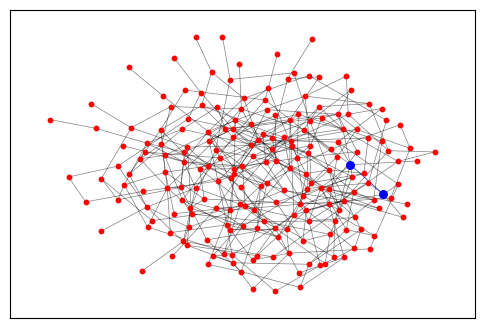

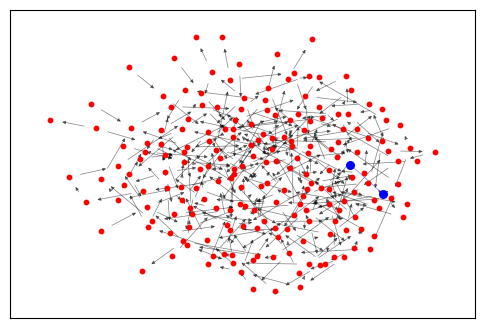

Porównanie wyników obu algorytmów(wartość funkcji cmp_vectors) dla grafu erdos_renyi_large: True
Sprawdzenie zgodności z pierwszym prawem Kirchoffa: True



-------------
Nazwa grafu: erdos_renyi_small
Ilość wierzchołków: 15
Ilość krawędzi: 21


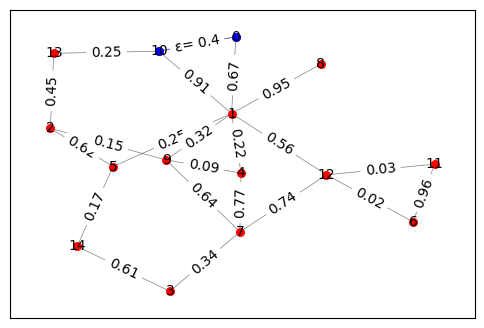

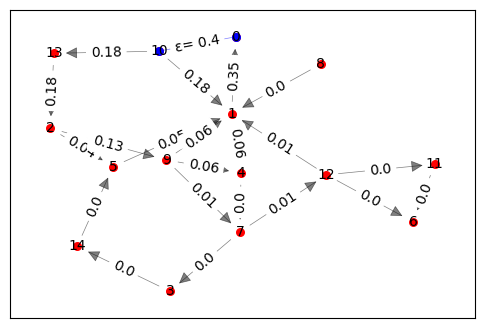

Porównanie wyników obu algorytmów(wartość funkcji cmp_vectors) dla grafu erdos_renyi_small: True
Sprawdzenie zgodności z pierwszym prawem Kirchoffa: True



-------------
Nazwa grafu: rectangular_mesh_large
Ilość wierzchołków: 400
Ilość krawędzi: 760


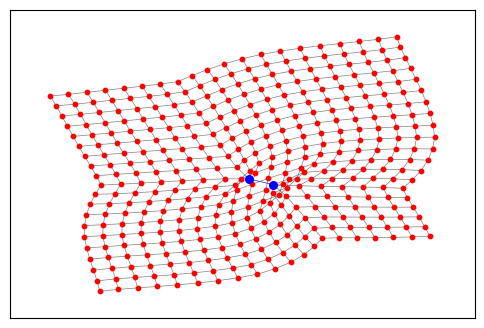

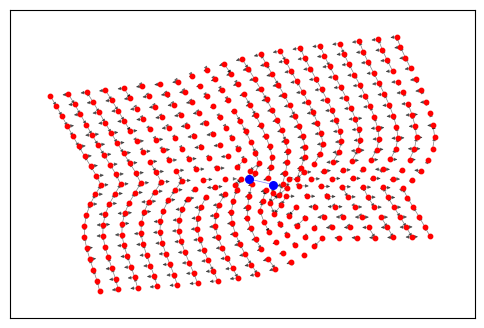

Porównanie wyników obu algorytmów(wartość funkcji cmp_vectors) dla grafu rectangular_mesh_large: True
Sprawdzenie zgodności z pierwszym prawem Kirchoffa: True



-------------
Nazwa grafu: rectangular_mesh_small
Ilość wierzchołków: 25
Ilość krawędzi: 40


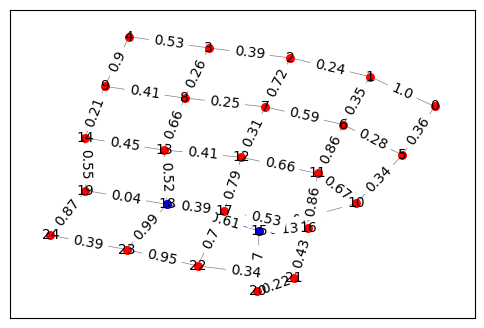

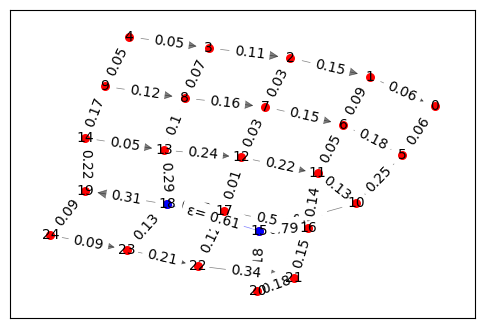

Porównanie wyników obu algorytmów(wartość funkcji cmp_vectors) dla grafu rectangular_mesh_small: True
Sprawdzenie zgodności z pierwszym prawem Kirchoffa: True



-------------
Nazwa grafu: smaller_world
Ilość wierzchołków: 20
Ilość krawędzi: 60


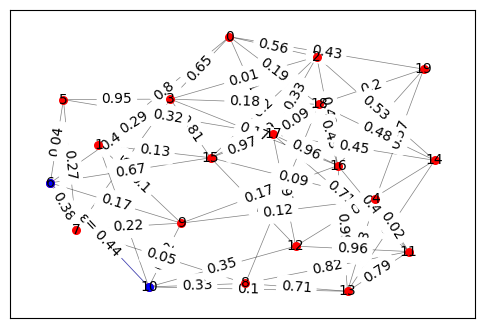

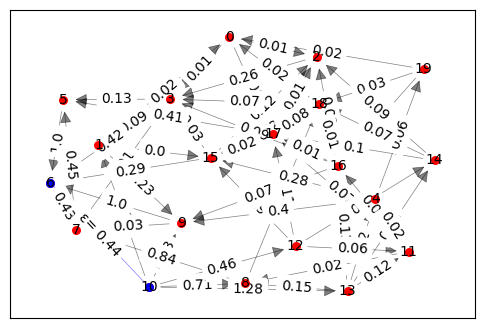

Porównanie wyników obu algorytmów(wartość funkcji cmp_vectors) dla grafu smaller_world: True
Sprawdzenie zgodności z pierwszym prawem Kirchoffa: True



-------------
Nazwa grafu: small_world
Ilość wierzchołków: 100
Ilość krawędzi: 1000


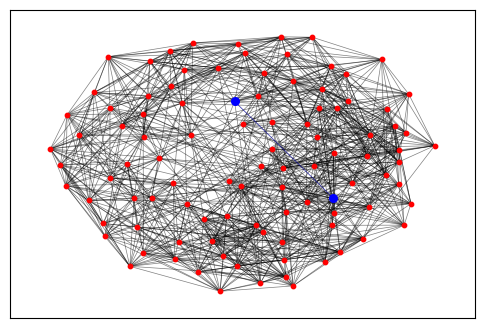

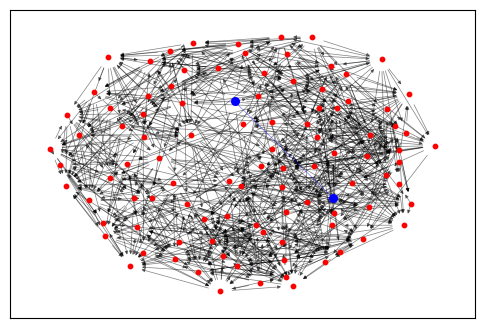

Porównanie wyników obu algorytmów(wartość funkcji cmp_vectors) dla grafu small_world: True
Sprawdzenie zgodności z pierwszym prawem Kirchoffa: True



-------------
Nazwa grafu: triangulation_large
Ilość wierzchołków: 750
Ilość krawędzi: 2141


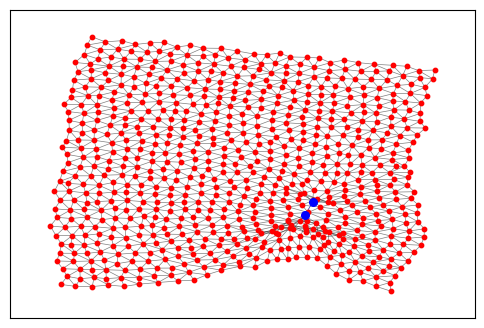

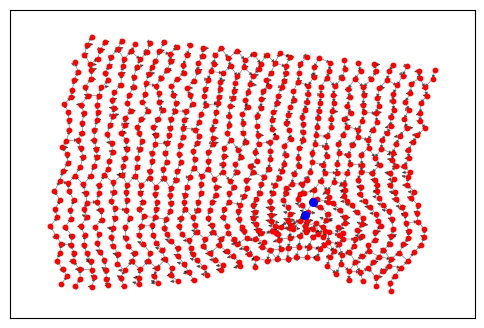

Porównanie wyników obu algorytmów(wartość funkcji cmp_vectors) dla grafu triangulation_large: True
Sprawdzenie zgodności z pierwszym prawem Kirchoffa: True



-------------
Nazwa grafu: triangulation_small
Ilość wierzchołków: 30
Ilość krawędzi: 68


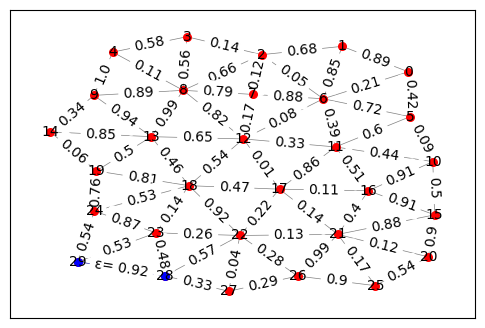

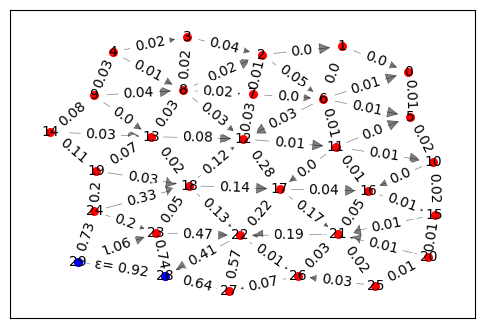

Porównanie wyników obu algorytmów(wartość funkcji cmp_vectors) dla grafu triangulation_small: True
Sprawdzenie zgodności z pierwszym prawem Kirchoffa: True





In [17]:
from os.path import isfile, join
from os import listdir

file_names = [f for f in listdir('saved_graphs') if isfile(join('saved_graphs', f))]
for f_name in file_names:
    print("-------------")
    G, source, target, E = gg.load_graph(f_name)
    print(f"Nazwa grafu: {f_name}")
    print(f"Ilość wierzchołków: {G.number_of_nodes()}")
    print(f"Ilość krawędzi: {G.number_of_edges() - 1}")
    small = True if G.number_of_nodes() <= 30 else False
    gv.draw_with_resistance(G, source, target, E, small=small, size_param=(6, 4))
    kirchoff(G, source, target, E)
    vector1 = save_current_values(G, source, target)
    nodal_potentials(G, source, target, E)
    vector2 = save_current_values(G, source, target)
    gv.draw_with_current(G, source, target, E, small=small, size_param=(6, 4))
    print(f"Porównanie wyników obu algorytmów(wartość funkcji cmp_vectors) dla grafu {f_name}: {cmp_vectors(vector1, vector2)}")
    print(f"Sprawdzenie zgodności z pierwszym prawem Kirchoffa: {check_currents(G, source, target)}")
    print("\n\n")

Dla dokładności 9 miejsc po przecinku, dla wszysktich grafów wartości zwrócone przez oba algorytmy były zbliżone
Dla dokładności 12 miejsc po przecinku wartości natężeń nie zgadzały się w całości dla grafu "small world" i "large_traingulation".
Jednak jest to bardzo mała dokładność, więc można wnioskować, że oba algorytmy były zaimplementowane poprawnie.

#### Wnioski
Oba algorytmy zwracają poprawne wyniki, lecz wwedług mnie dużo lepszą metodą jest metoda potencjałów węzłowych. Jest w prostsza w implementacji od praw Kirchoffa i nie wymaga znajdowania cykli bazowych. Jej główną zaletą jest jednak złożoność obliczeniowa. Najkosztowniejszym krokiem każdego algorytmu jest rozwiązanie układu równań. W metodzie potencjałów węzłowych dostajemy na końcu kwadratowy układ równań V x V (V to ilość węzłów w obwodzie), gdyż potancjał jest obliczany dla każdego wierzchołka. Korzystając z praw Kirchoffa, jako zmienne traktujemy natężenia, więc wiadomo, żę równań w układzie musi być rzędu E (E to ilość krawędzi). Dla grafów gęstych metoda praw Kirchoffa staje się całkowicie niewydajna
